# Prediction of Enhancers and Promoters with CNN

In [1]:
import pandas as pd
import numpy as np
from typing import Tuple, Dict
import os
import compress_json
from tqdm.auto import tqdm, trange
from plot_keras_history import plot_history
from barplots import barplots
import silence_tensorflow.auto

In [2]:
models = []

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC

def build_perceptron():
    perceptron = Sequential([
        Input(shape=(200, 4)),
        Flatten(),
        Dense(1, activation="sigmoid")
    ], "Perceptron")

    perceptron.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            AUC(curve="ROC", name="auroc"),
            AUC(curve="PR", name="auprc")
        ]
    )
    return perceptron

models.append(build_perceptron)

In [4]:
def build_mlp():
    mlp = Sequential([
        Input(shape=(200, 4)),
        Flatten(),
        Dense(64, activation="relu"),
        Dense(32, activation="relu"),
        Dense(1, activation="sigmoid")
    ], "MLP")

    mlp.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            AUC(curve="ROC", name="auroc"),
            AUC(curve="PR", name="auprc")
        ]
    )
    return mlp

models.append(build_mlp)

In [5]:
from tensorflow.keras.layers import BatchNormalization, Dropout, Activation

def build_ffnn():
    ffnn = Sequential([
        Input(shape=(200, 4)),
        Flatten(),
        Dense(128, activation="relu"),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(32, activation="relu"),
        Dense(16, activation="relu"),
        Dense(1, activation="sigmoid")
    ], "FFNN")

    ffnn.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            AUC(curve="ROC", name="auroc"),
            AUC(curve="PR", name="auprc")
        ]
    )
    return ffnn

models.append(build_ffnn)

In [6]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten, Input, Reshape, Conv1D, MaxPool1D, Activation

def build_deep_enhancers() -> Model:
    """Return Deep Enhancers fixed model.

    References
    -------------
    https://www.nature.com/articles/nmeth.2987
    """
    model = Sequential([
        Input((200, 4)),
        Conv1D(filters=128, kernel_size=8),
        BatchNormalization(),
        Activation("relu"),
        Conv1D(filters=128, kernel_size=8),
        BatchNormalization(),
        Activation("relu"),
        MaxPool1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3),
        BatchNormalization(),
        Activation("relu"),
        Conv1D(filters=64, kernel_size=3),
        BatchNormalization(),
        Activation("relu"),
        MaxPool1D(pool_size=2),
        Flatten(),
        Dense(units=256, activation="relu"),
        Dropout(rate=0.1),
        Dense(units=128, activation="relu"),
        Dropout(rate=0.1),
        Dense(units=1, activation="sigmoid"),
    ], name="DeepEnhancer")

    model.compile(
        optimizer="nadam",
        loss="binary_crossentropy",
        metrics=[
            AUC(curve='ROC', name="auroc"),
            AUC(curve='PR', name="auprc"),
            "accuracy"
        ]
    )

    return model

models.append(build_deep_enhancers)

In [7]:
from epigenomic_dataset import load_epigenomes
from sklearn.impute import KNNImputer
from typing import List, Dict

def filter_labels(
    positive_classes:List[str],
    negative_classes:List[str],
    bed:pd.DataFrame,
    epigenome:pd.DataFrame,
    labels:pd.DataFrame,
    dataset_name:str
):
    # Filtering data so to leave only data relative to requested classes
    mask = labels.isin(positive_classes+negative_classes).values
    labels = labels[mask]
    bed = bed[mask]
    epigenome = epigenome[mask]

    # Converting the classes to zero and ones.
    labels = labels.isin(positive_classes).values.astype(int)

    return {
        "bed":bed,
        "epigenome":epigenome,
        "labels":labels,
        "name":dataset_name
    }

def get_new_data(
    positive_classes:List[str],
    negative_classes:List[str],
    cell_line:str,
    window_size:int=200,
    dataset:str="fantom",
    directory:str="new_data",
)->Dict:
    promoters_data, promoters_labels = load_epigenomes(
        cell_line = cell_line,
        dataset = dataset,
        regions = "promoters",
        window_size = window_size,
        root = directory
    )
    enhancers_data, enhancers_labels = load_epigenomes(
        cell_line = cell_line,
        dataset = dataset,
        regions = "enhancers",
        window_size = window_size,
        root = directory
    )

    epigenome = pd.concat([
        promoters_data,
        enhancers_data
    ])

    imputer = KNNImputer(n_neighbors=3)
    epigenome = pd.DataFrame(
        imputer.fit_transform(epigenome),
        columns=epigenome.columns,
        index=epigenome.index
    )

    bed = epigenome.reset_index()[["chrom", "chromStart", "chromEnd", "strand"]]

    promoters_labels[promoters_labels==0] = "I-P"
    promoters_labels[promoters_labels==1] = "A-P"
    enhancers_labels[enhancers_labels==0] = "I-E"
    enhancers_labels[enhancers_labels==1] = "A-E"

    labels = pd.concat([
        promoters_labels,
        enhancers_labels
    ])
    
    return filter_labels(
        positive_classes,
        negative_classes,
        bed,
        epigenome,
        labels,
        dataset_name="NewData"
    )

In [8]:
from sklearn.model_selection import train_test_split
from keras_bed_sequence import BedSequence
from keras_mixed_sequence import MixedSequence, VectorSequence
from ucsc_genomes_downloader import Genome

def get_holdout(dataset:Dict, genome:Genome, random_state, test_size:float=0.2, batch_size:int=1024)->Tuple:
    """Return tuple with the training and test sequences, training and test epigenomic data and training and test labels.

    Parameters
    --------------------------
    dataset:Dict,
        Dataset to use to generate the training and test partitions.
    genome:Genome,
        The genomic assembly from where to extract the sequences.
    test_size:float=0.2,
        The test set percentage.
    batch_size:int=1024,
        The batch size to use for the sequences.

    Returns
    ---------------------------
    Sixtuple with training and test data for sequences, epigenomic data and labels.
    """
    bed_train, bed_test, epi_train, epi_test, y_train, y_test = train_test_split(
        dataset["bed"],
        dataset["epigenome"].values,
        dataset["labels"],
        test_size=test_size,
        random_state=random_state
    )

    training_sequence = MixedSequence(
        x=BedSequence(genome, bed_train, batch_size=batch_size),
        y=VectorSequence(y_train, batch_size=batch_size)
    )

    validation_sequence = MixedSequence(
        x=BedSequence(genome, bed_test, batch_size=batch_size),
        y=VectorSequence(y_test, batch_size=batch_size)
    )

    return training_sequence, validation_sequence, epi_train, epi_test, y_train, y_test

In [9]:
def precomputed(results, model:str, holdout:int)->bool:
    df = pd.DataFrame(results)
    if df.empty:
        return False
    return (
        (df.model == model) &
        (df.holdout == holdout)
    ).any()

In [10]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

if os.path.exists("sequence.json"):
    results = compress_json.local_load("sequence.json")
else:
    results = []
    
def to_normal_float(dictionary)->Dict:
    return {
        key: float(value) if isinstance(value, np.float32) else value
        for key, value in dictionary.items()
    }

genome = Genome("hg19", verbose=False)
data = get_new_data(["A-E", "I-E"], ["A-P", "I-P"], cell_line="GM12878", window_size=200)

for i in trange(50, desc="Computing holdouts", dynamic_ncols=True):
    train, test, _, _, _, _ = get_holdout(
        data, genome, random_state=i
    )
    for build_model in tqdm(models, total=len(models), desc="Training models", leave=False, dynamic_ncols=True):
        model = build_model()
        if precomputed(results, model.name, i):
            continue
        history = model.fit(
            train,
            steps_per_epoch=train.steps_per_epoch,
            validation_data=test,
            validation_steps=test.steps_per_epoch,
            epochs=1000,
            verbose=False,
            callbacks=[
                EarlyStopping(
                    monitor="val_loss",
                    mode="min",
                    patience=5,
                    restore_best_weights=True
                ),
            ]
        ).history
        
        results.append({
            "model":model.name,
            "run_type":"train",
            "holdout":i,
            **to_normal_float(dict(zip(model.metrics_names, model.evaluate(train, steps=train.steps_per_epoch, verbose=False)))),
        })
        results.append({
            "model":model.name,
            "run_type":"test",
            "holdout":i,
            **to_normal_float(dict(zip(model.metrics_names, model.evaluate(test, steps=test.steps_per_epoch, verbose=False)))),
        })
        compress_json.local_dump(results, "sequence.json")

In [11]:
df = pd.DataFrame(results).drop(columns="holdout")

In [12]:
df

,model,run_type,loss,accuracy,auroc,auprc
0,Perceptron,train,0.632171,0.631165,0.660640,0.527785
1,Perceptron,test,0.636587,0.627030,0.654989,0.524936
2,MLP,train,0.511673,0.737436,0.813316,0.717893
3,MLP,test,0.558896,0.695376,0.764455,0.648676
4,FFNN,train,0.520217,0.745390,0.817976,0.726148
...,...,...,...,...,...,...
395,MLP,test,0.559938,0.695920,0.763243,0.644204
396,FFNN,train,0.507170,0.754190,0.826895,0.739552
397,FFNN,test,0.557331,0.698249,0.766059,0.646758
398,DeepEnhancer,train,0.357385,0.834265,0.930702,0.886367


In [13]:
barplots(
    df,
    groupby=["model", "run_type"],
    show_legend=False,
    height=5,
    orientation="horizontal",
    path='barplots/sequence/{feature}.png',
)

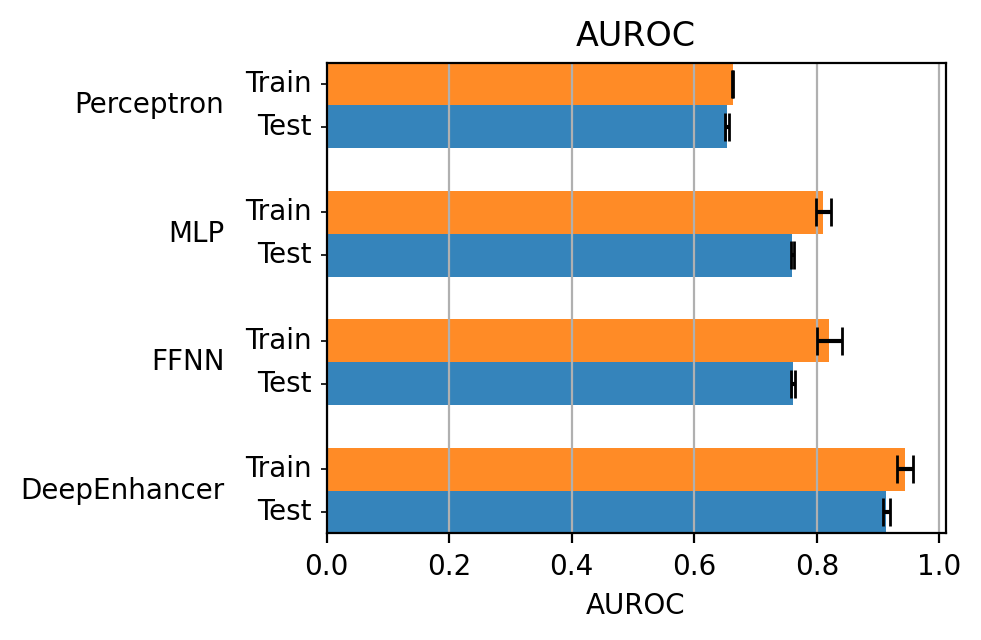

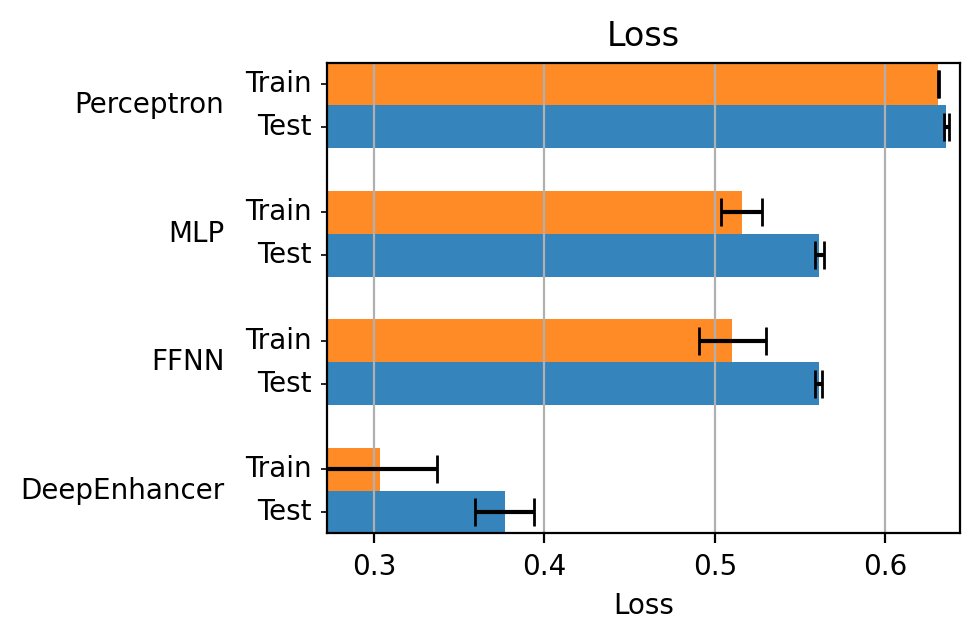

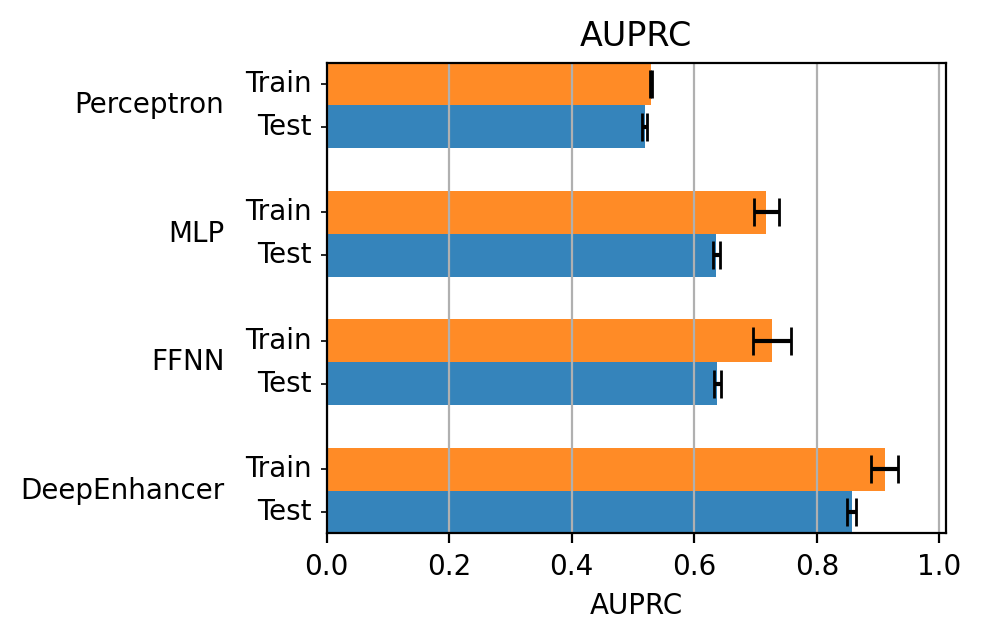

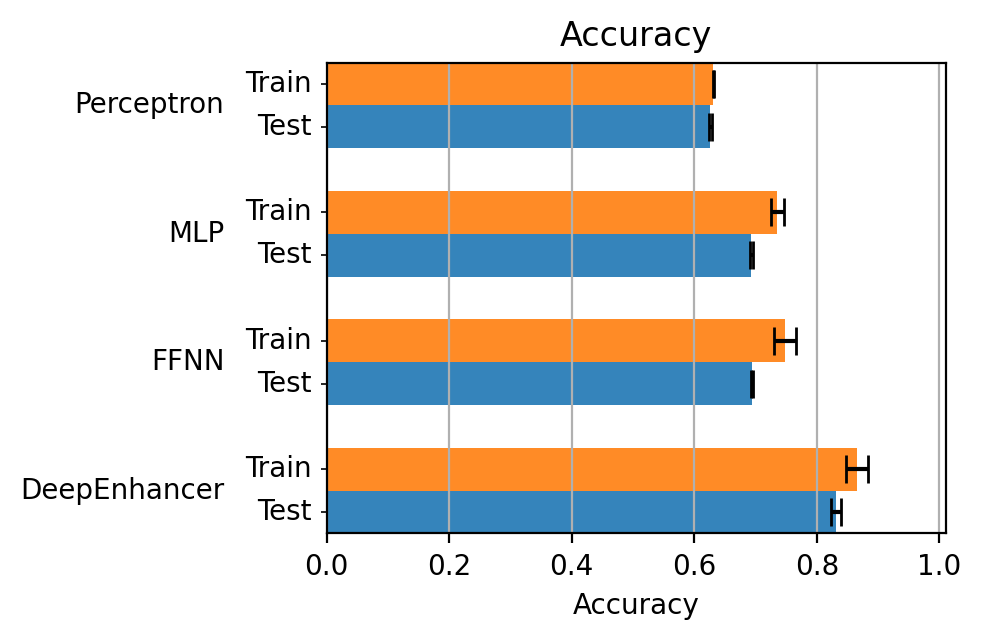

In [14]:
from PIL import Image
from glob import glob

for x in glob("barplots/sequence/*.png"):
    display(Image.open(x))